In [3]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def get_train_data():
    X = []
    y = []
    for i in range(1, 6):
        x1 = unpickle('cifar-10-python/cifar-10-batches-py/data_batch_'+str(i))
        y1 = x1[b'labels']
        x2 = x1[b'data']
        X += x2.tolist()
        y += y1
    return X, y

In [4]:
def get_test_data():
    x1 = unpickle('cifar-10-python/cifar-10-batches-py/test_batch')
    X = x1[b'data']
    y = x1[b'labels']
    return X, y

In [5]:
def as_numpy():
    X = np.array(X)

    X = np.reshape(X, (-1, 3, 32, 32))

    X = X.transpose(0, 2, 3, 1)

    X = X.astype(np.uint8)

    y = np.array(y)
    return X, y

In [6]:
def get_data(X, BATCH_SIZE):
    index = 0
    while True:
        b = random.choice([True, False])
        if index + BATCH_SIZE <= len(X):
            data = X[index:index+BATCH_SIZE]
            index += BATCH_SIZE
        else:
            np.random.shuffle(X)
            data = X[:BATCH_SIZE]
            index = BATCH_SIZE
        if b: 
            data = np.flip(data, axis = 2)
        yield data


def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], :] = img[:, :, :]
    return image

In [7]:
SAMPLES = 64*(10000 // 64)
SAMPLES

9984

In [4]:
X, y = as_numpy(get_train_data())
X.shape, y.shape

NameError: name 'X' is not defined

In [5]:
perm = np.random.permutation(len(X))

In [6]:
X = X[perm]
y = y[perm]

In [7]:
X = X[:SAMPLES]
y = y[:SAMPLES]

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
fetch_data = get_data(X, 64)

In [11]:
y[:64]

array([4, 1, 1, 2, 9, 3, 8, 1, 8, 3, 8, 0, 8, 5, 1, 9, 4, 9, 6, 1, 4, 7,
       4, 1, 2, 4, 0, 0, 4, 8, 4, 8, 7, 8, 6, 8, 7, 4, 0, 7, 1, 6, 7, 7,
       2, 9, 6, 0, 1, 6, 0, 5, 9, 7, 3, 3, 9, 1, 8, 1, 7, 8, 4, 2])

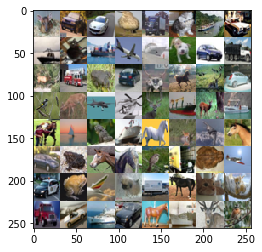

In [10]:
plt.imshow(combine_images(next(fetch_data)))
plt.show()

------

In [8]:
import tensorflow as tf
session = tf.Session()
imported_meta = tf.train.import_meta_graph("./model/model.ckpt-100000.meta")  
imported_meta.restore(session, tf.train.latest_checkpoint('./model/'))

INFO:tensorflow:Restoring parameters from ./model/model.ckpt-100000


In [9]:
writer = tf.summary.FileWriter("./log/", session.graph)

In [10]:
z = session.graph.get_tensor_by_name("Placeholder_1:0")
z

<tf.Tensor 'Placeholder_1:0' shape=(?, 128) dtype=float32>

In [11]:
is_training = session.graph.get_tensor_by_name("Placeholder:0")

In [12]:
image_input = session.graph.get_tensor_by_name("Placeholder_2:0")

In [13]:
critic_output = session.graph.get_tensor_by_name("Reshape_1:0")

In [14]:
fake_critic_output = session.graph.get_tensor_by_name("Reshape:0")

In [15]:
fake_image = session.graph.get_tensor_by_name("generator/Tanh:0")

In [16]:
fake_image

<tf.Tensor 'generator/Tanh:0' shape=(64, 32, 32, 3) dtype=float32>

In [17]:
Z = np.random.randn(9984, 128).astype(np.float32)

In [18]:
Z.dtype

dtype('float32')

In [19]:
d_fake = []
images= []
for i in range(int(len(Z)/64)):
    image, _d_fake = session.run([fake_image, fake_critic_output], feed_dict={z:Z[i*64:i*64+64], is_training:False})
    d_fake += _d_fake.tolist()
    images += image.tolist()

In [20]:
type(d_fake[0])

float

In [21]:
images = np.array(images)
images.shape, np.min(images), np.max(images), images.dtype

((9984, 32, 32, 3), -0.9999857544898987, 1.0, dtype('float64'))

In [22]:
d_fake = np.array(d_fake)
d_fake.shape

(9984,)

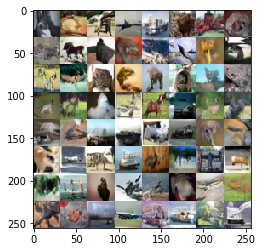

In [23]:
plt.imshow(combine_images(images[:64]/2 + 0.5))

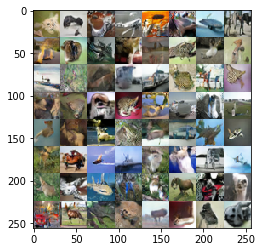

In [24]:
plt.imshow(combine_images(images[64:128]/2 + 0.5))

In [19]:
d_real = []

In [20]:
for i in range(int(len(X)/64)):
    d_real += list(session.run(critic_output, feed_dict={image_input:2*(X[i:i+64]/255.-0.5)}))

In [21]:
len(d_real)

9984

In [26]:
import seaborn as sns

/home/sudeep/.conda/envs/keras_gpu_tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


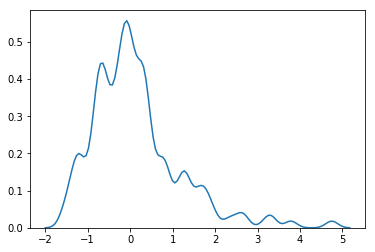

In [23]:

sns.kdeplot(d_real)

/home/sudeep/.conda/envs/keras_gpu_tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


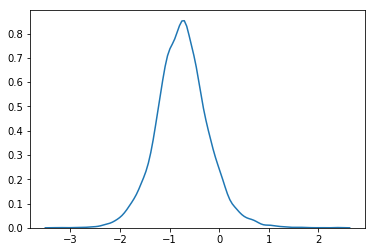

In [27]:
sns.kdeplot(d_fake)

In [28]:
real_dict = {"Z":Z, "images":images, "labels": None, "critic_outputs": d_fake}

In [5]:
import pickle

In [15]:
with open("generated_outputs.pkl", "wb") as f:
    pickle.dump(dicts, f)

In [7]:
with open("./stats/generated_outputs.pkl", "rb") as f:
    dicts = pickle.load(f)

In [8]:
dicts.keys()

dict_keys(['Z', 'images', 'labels', 'critic_outputs'])

In [9]:
images = dicts['images']

In [10]:
images.dtype

dtype('float64')

In [11]:
images = np.round(255*(images/2 + 0.5)).astype(np.uint8)

In [14]:
dicts['images'] = images